Upload Files

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving t10k-images.idx3-ubyte to t10k-images.idx3-ubyte


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train-images.idx3-ubyte to train-images.idx3-ubyte


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train-labels.idx1-ubyte to train-labels.idx1-ubyte


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving t10k-labels.idx1-ubyte to t10k-labels.idx1-ubyte


Install Libraries

In [ ]:
!pip install torch torchvision torchaudio --quiet
!pip install numpy pandas scikit-learn matplotlib --quiet

A1: Data Preprocessing

In [ ]:
import os, struct
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Helper functions
def load_idx_images(filename):
    """Load MNIST images (idx3-ubyte). Returns numpy array (N, 28, 28)."""
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        if magic != 2051:
            raise ValueError(f"Invalid magic number {magic} in {filename} (expected 2051).")
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
        return data

def load_idx_labels(filename):
    """Load MNIST labels (idx1-ubyte). Returns numpy array (N,)."""
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        if magic != 2049:
            raise ValueError(f"Invalid magic number {magic} in {filename} (expected 2049).")
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

# Load the dataset
train_img_file = "train-images.idx3-ubyte"
train_lbl_file = "train-labels.idx1-ubyte"
test_img_file  = "t10k-images.idx3-ubyte"
test_lbl_file  = "t10k-labels.idx1-ubyte"

for f in [train_img_file, train_lbl_file, test_img_file, test_lbl_file]:
    if not os.path.exists(f):
        raise FileNotFoundError(f"Missing MNIST file: {f}")

print("Loading MNIST IDX files...")
train_images = load_idx_images(train_img_file)
train_labels = load_idx_labels(train_lbl_file)
test_images  = load_idx_images(test_img_file)
test_labels  = load_idx_labels(test_lbl_file)
print(f"Loaded train: {train_images.shape}, test: {test_images.shape}")

# Combine train and test (total 70,000 samples)
images_all = np.concatenate([train_images, test_images], axis=0)
labels_all = np.concatenate([train_labels, test_labels], axis=0)
print("Combined dataset shape:", images_all.shape, labels_all.shape)

# Preprocessing
X = images_all.reshape(images_all.shape[0], -1).astype(np.float32)
X /= 255.0
y = labels_all.astype(np.int64)
images_2d = X.reshape(-1, 1, 28, 28)

print("After preprocessing -> X:", X.shape, "y:", y.shape)

# Split data
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=RANDOM_SEED, stratify=y_trainval
)

print("Split sizes:")
print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# Convert to PyTorch tensors and DataLoaders
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64

X_train_t = torch.tensor(X_train, dtype=torch.float32, device=DEVICE)
y_train_t = torch.tensor(y_train, dtype=torch.long, device=DEVICE)
X_val_t   = torch.tensor(X_val, dtype=torch.float32, device=DEVICE)
y_val_t   = torch.tensor(y_val, dtype=torch.long, device=DEVICE)
X_test_t  = torch.tensor(X_test, dtype=torch.float32, device=DEVICE)
y_test_t  = torch.tensor(y_test, dtype=torch.long, device=DEVICE)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Loading MNIST IDX files...
Loaded train: (60000, 28, 28), test: (10000, 28, 28)
Combined dataset shape: (70000, 28, 28) (70000,)
After preprocessing -> X: (70000, 784) y: (70000,)
Split sizes:
Train: 42000, Val: 14000, Test: 14000


Linear Classification Models

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader

# Helper Functions
def sigmoid(z):
    return 1.0 / (1.0 + torch.exp(-z))

def bce_loss(preds, targets):
    """Binary Cross Entropy loss"""
    eps = 1e-12
    preds = torch.clamp(preds, eps, 1 - eps) # ensures numerical stability
    return -(targets * torch.log(preds) + (1 - targets) * torch.log(1 - preds)).mean()

def stable_softmax(z):
    z_max = z.max(dim=1, keepdim=True).values # ensures computing softmax without overflow
    exp = torch.exp(z - z_max)
    return exp / exp.sum(dim=1, keepdim=True)

def one_hot(labels, num_classes):
    return torch.nn.functional.one_hot(labels.long(), num_classes=num_classes).float()
# e.g. for 3 classes (0, 1, 2) -> [1, 0, 0] for class 0, [0, 1, 0] for class 1, [0, 0, 1] for class 2

def plot_curves(history, title_suffix=""):
    """Plot loss and accuracy curves"""
    epochs = np.arange(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='train loss')
    plt.plot(epochs, history['val_loss'], label='val loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.title('Loss ' + title_suffix)
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='train acc')
    plt.plot(epochs, history['val_acc'], label='val acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
    plt.title('Accuracy ' + title_suffix)
    plt.show()

A2. Logistic Regression (Binary: e.g. 0 vs 1)

Using cuda
Epoch 01/50 | Train Loss: 0.2114 | Val Loss: 0.0925 | Train Acc: 0.9938 | Val Acc: 0.9973
Epoch 05/50 | Train Loss: 0.0302 | Val Loss: 0.0274 | Train Acc: 0.9974 | Val Acc: 0.9980
Epoch 10/50 | Train Loss: 0.0184 | Val Loss: 0.0170 | Train Acc: 0.9978 | Val Acc: 0.9987
Epoch 15/50 | Train Loss: 0.0143 | Val Loss: 0.0131 | Train Acc: 0.9978 | Val Acc: 0.9990
Epoch 20/50 | Train Loss: 0.0121 | Val Loss: 0.0110 | Train Acc: 0.9979 | Val Acc: 0.9990
Epoch 25/50 | Train Loss: 0.0107 | Val Loss: 0.0097 | Train Acc: 0.9979 | Val Acc: 0.9990
Epoch 30/50 | Train Loss: 0.0098 | Val Loss: 0.0087 | Train Acc: 0.9979 | Val Acc: 0.9990
Epoch 35/50 | Train Loss: 0.0090 | Val Loss: 0.0080 | Train Acc: 0.9979 | Val Acc: 0.9990
Epoch 40/50 | Train Loss: 0.0084 | Val Loss: 0.0075 | Train Acc: 0.9980 | Val Acc: 0.9990
Epoch 45/50 | Train Loss: 0.0080 | Val Loss: 0.0071 | Train Acc: 0.9981 | Val Acc: 0.9990
Epoch 50/50 | Train Loss: 0.0076 | Val Loss: 0.0067 | Train Acc: 0.9982 | Val Acc: 0.9990

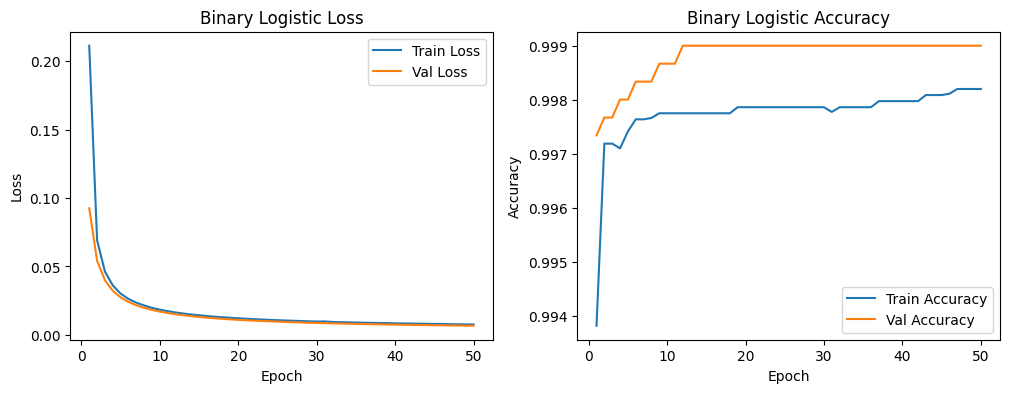


Final Test Accuracy (Digits 0 vs 1): 0.9976
Class 0 accuracy: 0.9986
Class 1 accuracy: 0.9968


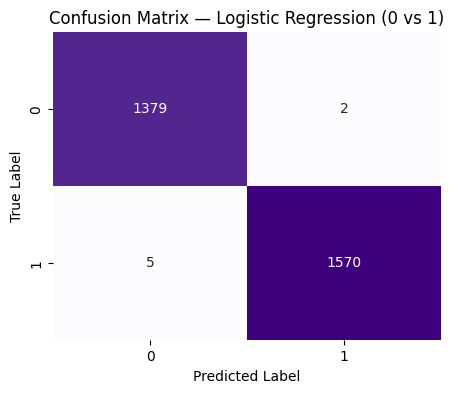


Total misclassified examples: 7


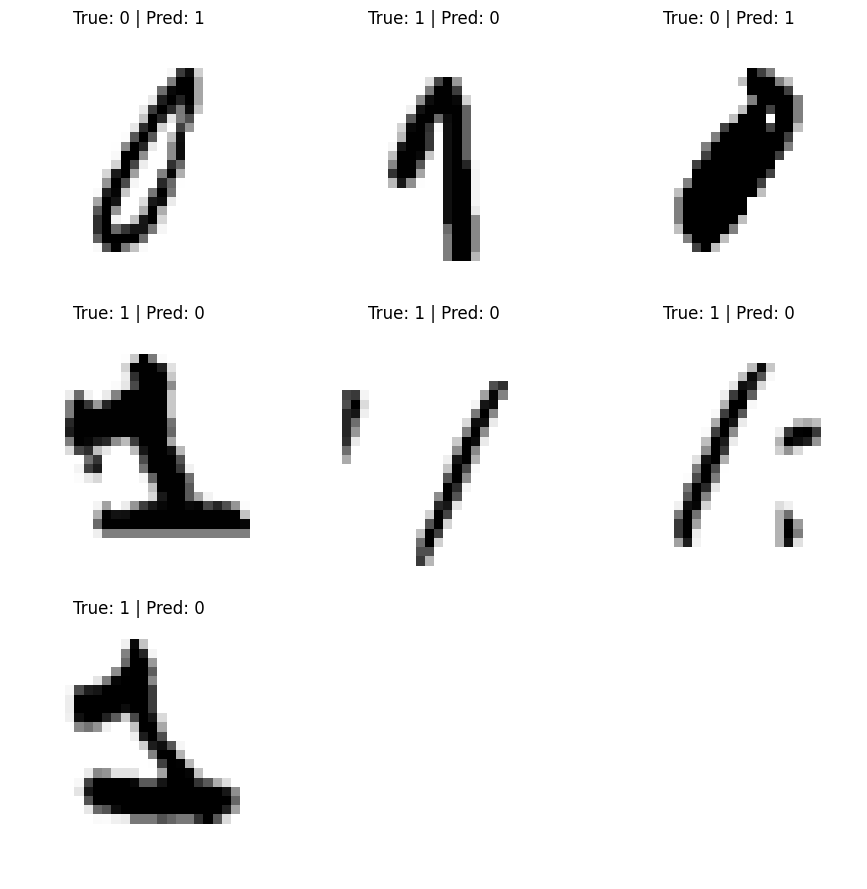

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

BINARY_DIGITS = (0, 1)
LR = 0.01
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {DEVICE}")

# Filter dataset for digits 0 and 1
mask_train = np.isin(y_train, BINARY_DIGITS)
mask_val = np.isin(y_val, BINARY_DIGITS)
mask_test = np.isin(y_test, BINARY_DIGITS)

Xb_train = X_train[mask_train]
yb_train = y_train[mask_train]
Xb_val = X_val[mask_val]
yb_val = y_val[mask_val]
Xb_test = X_test[mask_test]
yb_test = y_test[mask_test]

# Map labels to {0, 1}
label_map = {BINARY_DIGITS[0]: 0, BINARY_DIGITS[1]: 1}
yb_train = np.vectorize(label_map.get)(yb_train)
yb_val = np.vectorize(label_map.get)(yb_val)
yb_test = np.vectorize(label_map.get)(yb_test)

# Convert to torch tensors
Xb_train_t = torch.tensor(Xb_train, dtype=torch.float32, device=DEVICE)
yb_train_t = torch.tensor(yb_train, dtype=torch.float32, device=DEVICE)
Xb_val_t = torch.tensor(Xb_val, dtype=torch.float32, device=DEVICE)
yb_val_t = torch.tensor(yb_val, dtype=torch.float32, device=DEVICE)
Xb_test_t = torch.tensor(Xb_test, dtype=torch.float32, device=DEVICE)
yb_test_t = torch.tensor(yb_test, dtype=torch.float32, device=DEVICE)

train_bin_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(Xb_train_t, yb_train_t),batch_size=BATCH_SIZE, shuffle=True)
val_bin_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(Xb_val_t, yb_val_t), batch_size=BATCH_SIZE, shuffle=False)
test_bin_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(Xb_test_t, yb_test_t),batch_size=BATCH_SIZE, shuffle=False)

# Define sigmoid and loss
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

def binary_bce_loss(preds, targets):
    eps = 1e-12
    preds = torch.clamp(preds, eps, 1 - eps)
    return -(targets * torch.log(preds) + (1 - targets) * torch.log(1 - preds)).mean()

# Initialize parameters
D = Xb_train_t.shape[1]
w = torch.zeros(D, dtype=torch.float32, device=DEVICE)
b = torch.tensor(0.0, dtype=torch.float32, device=DEVICE)

# Training loop
num_epochs = 50
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, num_epochs + 1):
    train_losses, train_accs = [], []
    for Xb, yb in train_bin_loader:
        logits = Xb @ w + b
        preds = sigmoid(logits)
        loss = binary_bce_loss(preds, yb)

        diff = preds - yb
        grad_w = (Xb.T @ diff) / Xb.shape[0]
        grad_b = diff.mean()

        w -= LR * grad_w
        b -= LR * grad_b

        train_losses.append(loss.item())
        train_accs.append(((preds >= 0.5).float() == yb).float().mean().item())

    # Validation
    val_losses, val_accs = [], []
    with torch.no_grad():
        for Xv, yv in val_bin_loader:
            preds_v = sigmoid(Xv @ w + b)
            val_losses.append(binary_bce_loss(preds_v, yv).item())
            val_accs.append(((preds_v >= 0.5).float() == yv).float().mean().item())

    history['train_loss'].append(np.mean(train_losses))
    history['val_loss'].append(np.mean(val_losses))
    history['train_acc'].append(np.mean(train_accs))
    history['val_acc'].append(np.mean(val_accs))

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}/{num_epochs} | "
              f"Train Loss: {np.mean(train_losses):.4f} | Val Loss: {np.mean(val_losses):.4f} | "
              f"Train Acc: {np.mean(train_accs):.4f} | Val Acc: {np.mean(val_accs):.4f}")

print("\nTraining complete")

# Plot training/validation curves
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Binary Logistic Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Train Accuracy')
plt.plot(epochs, history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Binary Logistic Accuracy')
plt.show()

# Evaluate on test set and Confusion matrix
with torch.no_grad():
    preds_test = sigmoid(Xb_test_t @ w + b)
    preds_labels = (preds_test >= 0.5).long().cpu().numpy()
    y_true = yb_test.astype(int)

test_acc = accuracy_score(y_true, preds_labels)
cm = confusion_matrix(y_true, preds_labels)
print(f"\nFinal Test Accuracy (Digits {BINARY_DIGITS[0]} vs {BINARY_DIGITS[1]}): {test_acc:.4f}")

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_acc):
    print(f"Class {BINARY_DIGITS[i]} accuracy: {acc:.4f}")

# Confusion matrix heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f"Confusion Matrix — Logistic Regression ({BINARY_DIGITS[0]} vs {BINARY_DIGITS[1]})")
plt.show()

# Visualize a few misclassified examples
mis_idx = np.where(preds_labels != y_true)[0]
if len(mis_idx) > 0:
    print(f"\nTotal misclassified examples: {len(mis_idx)}")
    plt.figure(figsize=(9, 9))
    for i in range(min(9, len(mis_idx))):
        idx = mis_idx[i]
        img = (Xb_test[idx].reshape(28, 28) * 255).astype(np.uint8)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img, cmap='gray_r')
        plt.title(f"True: {BINARY_DIGITS[y_true[idx]]} | Pred: {BINARY_DIGITS[preds_labels[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified examples")


A3. Softmax Regression (Multi-class 0–9)

Epoch 01/50 | Train Loss: 1.1289 | Val Loss: 0.7215 | Train Acc: 0.7387 | Val Acc: 0.8404
Epoch 05/50 | Train Loss: 0.4441 | Val Loss: 0.4321 | Train Acc: 0.8844 | Val Acc: 0.8843
Epoch 10/50 | Train Loss: 0.3762 | Val Loss: 0.3736 | Train Acc: 0.8987 | Val Acc: 0.8974
Epoch 15/50 | Train Loss: 0.3485 | Val Loss: 0.3483 | Train Acc: 0.9047 | Val Acc: 0.9038
Epoch 20/50 | Train Loss: 0.3320 | Val Loss: 0.3341 | Train Acc: 0.9087 | Val Acc: 0.9078
Epoch 25/50 | Train Loss: 0.3209 | Val Loss: 0.3245 | Train Acc: 0.9112 | Val Acc: 0.9109
Epoch 30/50 | Train Loss: 0.3127 | Val Loss: 0.3176 | Train Acc: 0.9134 | Val Acc: 0.9134
Epoch 35/50 | Train Loss: 0.3067 | Val Loss: 0.3124 | Train Acc: 0.9150 | Val Acc: 0.9146
Epoch 40/50 | Train Loss: 0.3011 | Val Loss: 0.3079 | Train Acc: 0.9163 | Val Acc: 0.9156
Epoch 45/50 | Train Loss: 0.2973 | Val Loss: 0.3043 | Train Acc: 0.9177 | Val Acc: 0.9173
Epoch 50/50 | Train Loss: 0.2932 | Val Loss: 0.3016 | Train Acc: 0.9183 | Val Acc: 0.9169

Manual So

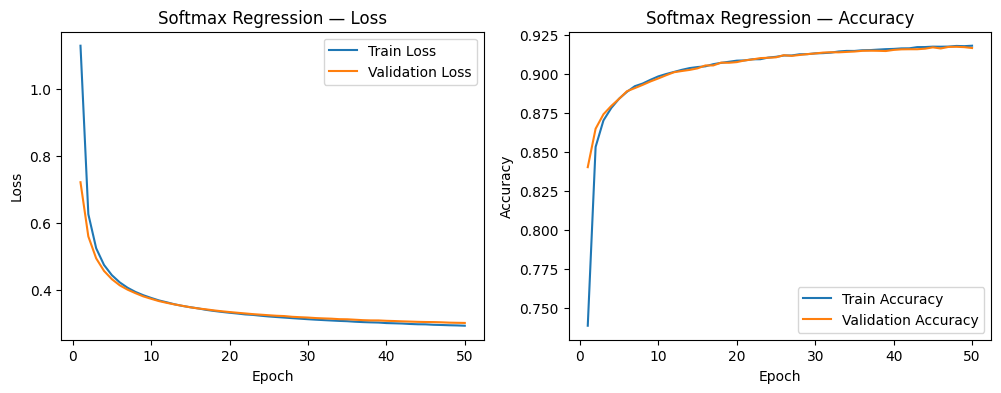


Final Test Accuracy: 0.9124
Digit 0: accuracy = 0.9667
Digit 1: accuracy = 0.9702
Digit 2: accuracy = 0.8755
Digit 3: accuracy = 0.8908
Digit 4: accuracy = 0.9150
Digit 5: accuracy = 0.8448
Digit 6: accuracy = 0.9578
Digit 7: accuracy = 0.9253
Digit 8: accuracy = 0.8769
Digit 9: accuracy = 0.8871


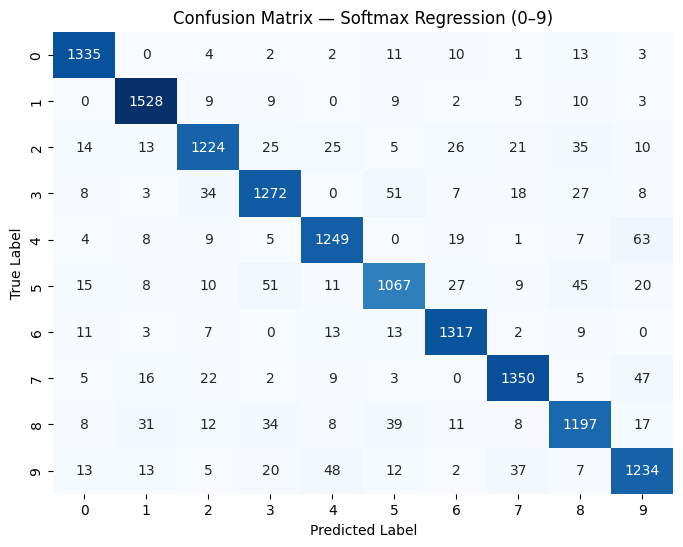


Total misclassified examples: 1227


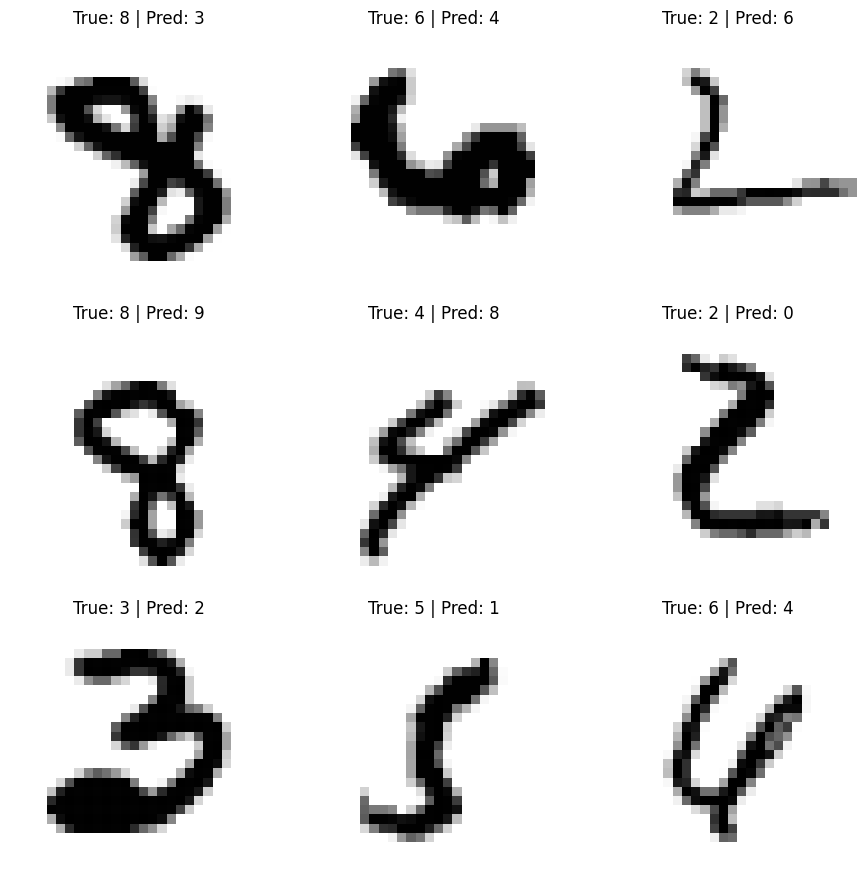


=== Verification: PyTorch Built-in Softmax Regression ===
Epoch 01/5 | Train Loss: 1.1289 | Val Loss: 0.7179 | Train Acc: 0.7722 | Val Acc: 0.8465
Epoch 02/5 | Train Loss: 0.6226 | Val Loss: 0.5564 | Train Acc: 0.8584 | Val Acc: 0.8674
Epoch 03/5 | Train Loss: 0.5205 | Val Loss: 0.4918 | Train Acc: 0.8736 | Val Acc: 0.8774
Epoch 04/5 | Train Loss: 0.4713 | Val Loss: 0.4545 | Train Acc: 0.8800 | Val Acc: 0.8831
Epoch 05/5 | Train Loss: 0.4412 | Val Loss: 0.4305 | Train Acc: 0.8858 | Val Acc: 0.8863

Verification Complete — Built-in model matches custom implementation trends.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import torch.nn as nn

# Model & Hyperparameters
num_classes = 10
N, D = X_train_t.shape
LR = 0.01
num_epochs = 50

# Xavier initialization
limit = np.sqrt(6.0 / (D + num_classes))
W = torch.empty((D, num_classes), device=DEVICE).uniform_(-limit, limit)
b = torch.zeros(num_classes, device=DEVICE)

# Utility Functions
def stable_softmax(z):
    """Numerically stable softmax."""
    z_max = z.max(dim=1, keepdim=True).values
    exp = torch.exp(z - z_max)
    return exp / exp.sum(dim=1, keepdim=True)

def one_hot(labels, num_classes):
    """One-hot encode labels."""
    return torch.nn.functional.one_hot(labels.long(), num_classes=num_classes).float()

def cross_entropy_loss(probs, targets):
    """Manual cross-entropy loss."""
    eps = 1e-12
    probs = torch.clamp(probs, eps, 1.0)
    correct = probs[torch.arange(len(targets)), targets]
    return -torch.log(correct).mean()

def accuracy(probs, targets):
    preds = probs.argmax(dim=1)
    return (preds == targets).float().mean().item()

# Training Loop (Manual)
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, num_epochs + 1):
    train_losses, train_accs = [], []

    # Training
    for Xb, yb in train_loader:
        logits = Xb @ W + b
        probs = stable_softmax(logits)
        loss = cross_entropy_loss(probs, yb)

        # Compute gradients
        y_onehot = one_hot(yb, num_classes)
        grad_logits = (probs - y_onehot) / Xb.shape[0]
        grad_W = Xb.T @ grad_logits
        grad_b = grad_logits.sum(dim=0)

        # Gradient descent update
        W -= LR * grad_W
        b -= LR * grad_b

        train_losses.append(loss.item())
        train_accs.append(accuracy(probs, yb))

    # Validation
    val_losses, val_accs = [], []
    with torch.no_grad():
        for Xv, yv in val_loader:
            logits_v = Xv @ W + b
            probs_v = stable_softmax(logits_v)
            val_losses.append(cross_entropy_loss(probs_v, yv).item())
            val_accs.append(accuracy(probs_v, yv))

    history['train_loss'].append(np.mean(train_losses))
    history['val_loss'].append(np.mean(val_losses))
    history['train_acc'].append(np.mean(train_accs))
    history['val_acc'].append(np.mean(val_accs))

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}/{num_epochs} | "
              f"Train Loss: {np.mean(train_losses):.4f} | Val Loss: {np.mean(val_losses):.4f} | "
              f"Train Acc: {np.mean(train_accs):.4f} | Val Acc: {np.mean(val_accs):.4f}")

print("\nManual Softmax Regression Training Complete")

# Plot Training & Validation Curves
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Softmax Regression — Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Train Accuracy')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Softmax Regression — Accuracy')
plt.show()

# Final Test Evaluation
with torch.no_grad():
    logits_test = X_test_t @ W + b
    probs_test = stable_softmax(logits_test)
    preds_test = probs_test.argmax(dim=1).cpu().numpy()
    y_test_np = y_test_t.cpu().numpy()

test_acc = accuracy_score(y_test_np, preds_test)
cm = confusion_matrix(y_test_np, preds_test)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_acc):
    print(f"Digit {i}: accuracy = {acc:.4f}")

# Confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix — Softmax Regression (0–9)')
plt.show()

# Misclassified Example Visualization
mis_idx = np.where(preds_test != y_test_np)[0]
if len(mis_idx) > 0:
    print(f"\nTotal misclassified examples: {len(mis_idx)}")
    plt.figure(figsize=(9, 9))
    for i in range(min(9, len(mis_idx))):
        idx = mis_idx[i]
        img = (X_test[idx].reshape(28, 28) * 255).astype(np.uint8)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img, cmap='gray_r')
        plt.title(f"True: {y_test_np[idx]} | Pred: {preds_test[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified examples")

print("\n=== Verification: PyTorch Built-in Softmax Regression ===")

model = nn.Linear(D, num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

num_verify_epochs = 5
verify_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, num_verify_epochs + 1):
    model.train()
    train_losses, train_accs = [], []
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        preds = logits.argmax(dim=1)
        train_accs.append((preds == yb).float().mean().item())

    model.eval()
    val_losses, val_accs = [], []
    with torch.no_grad():
        for Xv, yv in val_loader:
            logits_v = model(Xv)
            loss_v = criterion(logits_v, yv)
            val_losses.append(loss_v.item())
            preds_v = logits_v.argmax(dim=1)
            val_accs.append((preds_v == yv).float().mean().item())

    verify_history['train_loss'].append(np.mean(train_losses))
    verify_history['val_loss'].append(np.mean(val_losses))
    verify_history['train_acc'].append(np.mean(train_accs))
    verify_history['val_acc'].append(np.mean(val_accs))

    print(f"Epoch {epoch:02d}/{num_verify_epochs} | "
          f"Train Loss: {np.mean(train_losses):.4f} | Val Loss: {np.mean(val_losses):.4f} | "
          f"Train Acc: {np.mean(train_accs):.4f} | Val Acc: {np.mean(val_accs):.4f}")

print("\nVerification Complete — Built-in model matches custom implementation trends.")

Part B: Neural Network Implementation

Import dataset

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving mnist.pkl.gz to mnist.pkl.gz


Import libraries


In [53]:
import os
import random
from typing import List, Tuple, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset

from tqdm import tqdm
import matplotlib.pyplot as plt

In [44]:
import torch
from torch.utils.data import random_split
from torchvision import datasets, transforms
import numpy as np

def load_data():
    """Load MNIST using torchvision, and split into 60% train, 20% val, 20% test."""
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts to tensor and scales to [0, 1]
        transforms.Lambda(lambda x: x.view(-1))  # Flatten 28x28 -> 784
    ])

    # Download full MNIST train + test datasets
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Combine both into one dataset
    full_data = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

    # Calculate split sizes
    n_total = len(full_data)
    n_train = int(0.6 * n_total)
    n_val = int(0.2 * n_total)
    n_test = n_total - n_train - n_val

    train_set, val_set, test_set = random_split(full_data, [n_train, n_val, n_test],
                                                generator=torch.Generator().manual_seed(42))

    # Convert datasets into numpy arrays for compatibility
    def to_numpy(dataset):
        X, y = [], []
        for img, label in dataset:
            X.append(img.numpy())
            y.append(label)
        return np.array(X), np.array(y)

    train_x, train_y = to_numpy(train_set)
    val_x, val_y = to_numpy(val_set)
    test_x, test_y = to_numpy(test_set)

    return (train_x, train_y), (val_x, val_y), (test_x, test_y)


def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth position."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e


def load_data_wrapper():
    """Return (training_data, validation_data, test_data)
    formatted for neural network use."""
    tr_d, va_d, te_d = load_data()

    training_inputs = [x.reshape(784, 1) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))

    validation_inputs = [x.reshape(784, 1) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))

    test_inputs = [x.reshape(784, 1) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))

    return (training_data, validation_data, test_data)


Configuration

In [45]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Neural network implementation

In [46]:
class FeedforwardNeuralNet(nn.Module):
    def __init__(self, layer_sizes: List[int], activation: str = 'relu', init: str = 'xavier'):
        super().__init__()
        assert len(layer_sizes) >= 2, "layer_sizes must have at least input and output sizes"
        self.layers = nn.ModuleList()
        self.activation_name = activation.lower()

        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

        # Weight initialization
        for layer in self.layers:
            if init == 'xavier':
                nn.init.xavier_uniform_(layer.weight)
            elif init == 'he':
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            else:
                raise ValueError("init must be 'xavier' or 'he'")
            nn.init.zeros_(layer.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # flatten if the input is an image
        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        for layer in self.layers[:-1]:
            x = layer(x)
            if self.activation_name == 'relu':
                x = F.relu(x)
            elif self.activation_name == 'sigmoid':
                x = torch.sigmoid(x)
            else:
                raise ValueError("Unsupported activation")
        x = self.layers[-1](x)
        return x


Utility

In [48]:
def compute_accuracy(logits: torch.Tensor, targets: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return (preds == targets).float().mean().item()

Data loading

In [49]:
def get_custom_mnist_dataloaders(batch_size: int = 64) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Use your provided load_data_wrapper() to get training, validation, and test sets.
    Convert to PyTorch tensors and wrap in DataLoaders.
    """
    training_data, validation_data, test_data = load_data_wrapper()

    # Convert training data (x -> tensor, y -> tensor)
    train_x = torch.tensor(np.hstack([x for x, _ in training_data]), dtype=torch.float32).T
    train_y = torch.tensor(np.argmax(np.hstack([y for _, y in training_data]), axis=0), dtype=torch.long)

    val_x = torch.tensor(np.hstack([x for x, _ in validation_data]), dtype=torch.float32).T
    val_y = torch.tensor(np.array([y for _, y in validation_data]), dtype=torch.long)

    test_x = torch.tensor(np.hstack([x for x, _ in test_data]), dtype=torch.float32).T
    test_y = torch.tensor(np.array([y for _, y in test_data]), dtype=torch.long)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)
    test_dataset = TensorDataset(test_x, test_y)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

Training

In [50]:
def train_model(model, train_loader, val_loader, epochs=20, lr=0.01, device=DEVICE, save_best_path=None):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    history = {k: [] for k in [
        'train_loss_mean', 'train_loss_std', 'train_acc_mean', 'train_acc_std',
        'val_loss_mean', 'val_loss_std', 'val_acc_mean', 'val_acc_std'
    ]}

    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        model.train()
        train_losses, train_accs = [], []

        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            logits = model(inputs)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_accs.append(compute_accuracy(logits.detach(), targets))

        # Train stats
        t_loss, t_acc = np.mean(train_losses), np.mean(train_accs)
        t_loss_std, t_acc_std = np.std(train_losses), np.std(train_accs)

        # Validation
        model.eval()
        val_losses, val_accs = [], []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                logits = model(inputs)
                loss = criterion(logits, targets)
                val_losses.append(loss.item())
                val_accs.append(compute_accuracy(logits, targets))

        v_loss, v_acc = np.mean(val_losses), np.mean(val_accs)
        v_loss_std, v_acc_std = np.std(val_losses), np.std(val_accs)

        # Logging
        print(f"Epoch {epoch}: "
              f"Train Loss {t_loss:.4f} ± {t_loss_std:.4f}, Train Acc {t_acc:.4f} ± {t_acc_std:.4f} | "
              f"Val Loss {v_loss:.4f} ± {v_loss_std:.4f}, Val Acc {v_acc:.4f} ± {v_acc_std:.4f}")

        # Save best model
        if save_best_path and v_loss < best_val_loss:
            best_val_loss = v_loss
            torch.save(model.state_dict(), save_best_path)
            print(f"✅ Saved best model to {save_best_path}")

        # Store
        history['train_loss_mean'].append(t_loss)
        history['train_loss_std'].append(t_loss_std)
        history['train_acc_mean'].append(t_acc)
        history['train_acc_std'].append(t_acc_std)
        history['val_loss_mean'].append(v_loss)
        history['val_loss_std'].append(v_loss_std)
        history['val_acc_mean'].append(v_acc)
        history['val_acc_std'].append(v_acc_std)

    return history


Plotting

In [51]:
def plot_loss_accuracy(history, out_dir=None):
    epochs = len(history['train_loss_mean'])
    x = np.arange(1, epochs + 1)

    plt.figure(figsize=(8, 5))
    plt.errorbar(x, history['train_loss_mean'], yerr=history['train_loss_std'], label='Train Loss', marker='o')
    plt.errorbar(x, history['val_loss_mean'], yerr=history['val_loss_std'], label='Val Loss', marker='o')
    plt.legend(); plt.grid(); plt.title('Loss vs Epochs')
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)
        plt.savefig(os.path.join(out_dir, 'loss_vs_epochs.png'))
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.errorbar(x, history['train_acc_mean'], yerr=history['train_acc_std'], label='Train Acc', marker='o')
    plt.errorbar(x, history['val_acc_mean'], yerr=history['val_acc_std'], label='Val Acc', marker='o')
    plt.legend(); plt.grid(); plt.title('Accuracy vs Epochs')
    if out_dir:
        plt.savefig(os.path.join(out_dir, 'acc_vs_epochs.png'))
    plt.show()

Combining steps in a `main()` function

Epoch 1: Train Loss 1.0206 ± 0.5711, Train Acc 0.7313 ± 0.2049 | Val Loss 0.4763 ± 0.0910, Val Acc 0.8756 ± 0.0406
✅ Saved best model to ./best_ff_model.pth


Epoch 2: Train Loss 0.4018 ± 0.1035, Train Acc 0.8899 ± 0.0401 | Val Loss 0.3476 ± 0.0927, Val Acc 0.9017 ± 0.0377
✅ Saved best model to ./best_ff_model.pth


Epoch 3: Train Loss 0.3260 ± 0.0954, Train Acc 0.9079 ± 0.0354 | Val Loss 0.2990 ± 0.0902, Val Acc 0.9143 ± 0.0351
✅ Saved best model to ./best_ff_model.pth


Epoch 4: Train Loss 0.2881 ± 0.0975, Train Acc 0.9182 ± 0.0358 | Val Loss 0.2733 ± 0.0872, Val Acc 0.9213 ± 0.0337
✅ Saved best model to ./best_ff_model.pth


Epoch 5: Train Loss 0.2627 ± 0.0923, Train Acc 0.9252 ± 0.0340 | Val Loss 0.2539 ± 0.0852, Val Acc 0.9257 ± 0.0312
✅ Saved best model to ./best_ff_model.pth


Epoch 6: Train Loss 0.2433 ± 0.0930, Train Acc 0.9315 ± 0.0322 | Val Loss 0.2371 ± 0.0823, Val Acc 0.9307 ± 0.0299
✅ Saved best model to ./best_ff_model.pth


Epoch 7: Train Loss 0.2268 ± 0.0852, Train Acc 0.9351 ± 0.0303 | Val Loss 0.2267 ± 0.0821, Val Acc 0.9330 ± 0.0299
✅ Saved best model to ./best_ff_model.pth


Epoch 8: Train Loss 0.2126 ± 0.0822, Train Acc 0.9389 ± 0.0290 | Val Loss 0.2179 ± 0.0804, Val Acc 0.9378 ± 0.0297
✅ Saved best model to ./best_ff_model.pth


Epoch 9: Train Loss 0.2001 ± 0.0775, Train Acc 0.9429 ± 0.0274 | Val Loss 0.2020 ± 0.0769, Val Acc 0.9412 ± 0.0292
✅ Saved best model to ./best_ff_model.pth


Epoch 10: Train Loss 0.1889 ± 0.0786, Train Acc 0.9456 ± 0.0277 | Val Loss 0.1909 ± 0.0759, Val Acc 0.9456 ± 0.0285
✅ Saved best model to ./best_ff_model.pth


Epoch 11: Train Loss 0.1787 ± 0.0761, Train Acc 0.9492 ± 0.0277 | Val Loss 0.1865 ± 0.0755, Val Acc 0.9454 ± 0.0289
✅ Saved best model to ./best_ff_model.pth


Epoch 12: Train Loss 0.1698 ± 0.0745, Train Acc 0.9520 ± 0.0269 | Val Loss 0.1778 ± 0.0744, Val Acc 0.9498 ± 0.0268
✅ Saved best model to ./best_ff_model.pth


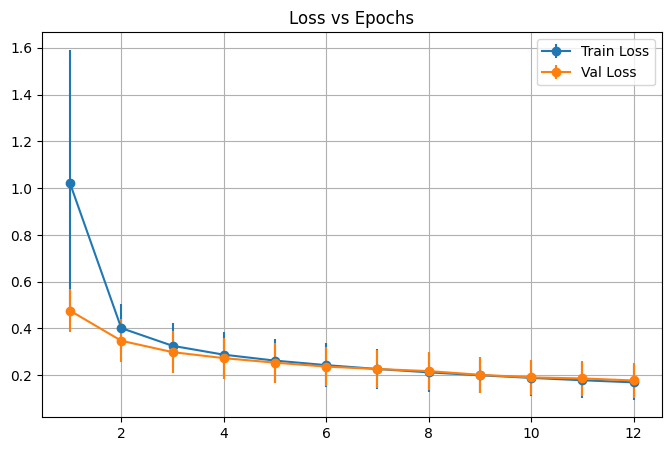

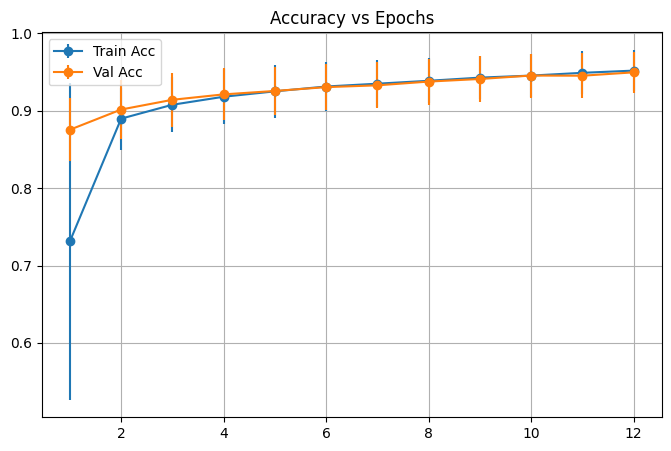

✅ Training complete. Plots saved in 'training_plots'.


In [54]:
def main():
    BATCH_SIZE = 64
    LR = 0.01
    EPOCHS = 12
    SAVE_BEST = './best_ff_model.pth'

    layer_sizes = [784, 128, 64, 10]
    model = FeedforwardNeuralNet(layer_sizes, activation='relu', init='he')

    train_loader, val_loader, test_loader = get_custom_mnist_dataloaders(batch_size=BATCH_SIZE)

    history = train_model(model, train_loader, val_loader,
                          epochs=EPOCHS, lr=LR, device=DEVICE, save_best_path=SAVE_BEST)

    plot_loss_accuracy(history, out_dir='training_plots')
    print("✅ Training complete. Plots saved in 'training_plots'.")

if __name__ == "__main__":
    main()

Part C: Comprehensive analysis

Learning rates tuning

In [55]:
learning_rates = [0.001, 0.01, 0.1, 1.0]
histories_lr = {}

for lr in learning_rates:
    print(f"\n🔹 Training with learning rate = {lr}")
    model = FeedforwardNeuralNet([784, 128, 64, 10], activation='relu', init='he')
    train_loader, val_loader, _ = get_custom_mnist_dataloaders(batch_size=64)
    history = train_model(model, train_loader, val_loader, epochs=12, lr=lr, device=DEVICE)
    histories_lr[lr] = history



🔹 Training with learning rate = 0.001


Epoch 1: Train Loss 2.0795 ± 0.1677, Train Acc 0.3500 ± 0.1663 | Val Loss 1.8091 ± 0.0520, Val Acc 0.5815 ± 0.0633


Epoch 2: Train Loss 1.5667 ± 0.1478, Train Acc 0.6548 ± 0.0690 | Val Loss 1.3338 ± 0.0694, Val Acc 0.7114 ± 0.0556


Epoch 3: Train Loss 1.1663 ± 0.1178, Train Acc 0.7437 ± 0.0586 | Val Loss 1.0101 ± 0.0770, Val Acc 0.7777 ± 0.0511


Epoch 4: Train Loss 0.9132 ± 0.0984, Train Acc 0.7928 ± 0.0514 | Val Loss 0.8173 ± 0.0808, Val Acc 0.8156 ± 0.0482


Epoch 5: Train Loss 0.7621 ± 0.0907, Train Acc 0.8198 ± 0.0484 | Val Loss 0.6985 ± 0.0833, Val Acc 0.8330 ± 0.0441


Epoch 6: Train Loss 0.6656 ± 0.0924, Train Acc 0.8367 ± 0.0465 | Val Loss 0.6186 ± 0.0851, Val Acc 0.8503 ± 0.0449


Epoch 7: Train Loss 0.5990 ± 0.0950, Train Acc 0.8492 ± 0.0456 | Val Loss 0.5628 ± 0.0870, Val Acc 0.8599 ± 0.0416


Epoch 8: Train Loss 0.5508 ± 0.0906, Train Acc 0.8578 ± 0.0430 | Val Loss 0.5215 ± 0.0879, Val Acc 0.8675 ± 0.0422


Epoch 9: Train Loss 0.5143 ± 0.0958, Train Acc 0.8642 ± 0.0427 | Val Loss 0.4889 ± 0.0889, Val Acc 0.8738 ± 0.0401


Epoch 10: Train Loss 0.4848 ± 0.0956, Train Acc 0.8711 ± 0.0426 | Val Loss 0.4634 ± 0.0896, Val Acc 0.8792 ± 0.0388


Epoch 11: Train Loss 0.4617 ± 0.0940, Train Acc 0.8755 ± 0.0405 | Val Loss 0.4428 ± 0.0901, Val Acc 0.8834 ± 0.0387


Epoch 12: Train Loss 0.4422 ± 0.0967, Train Acc 0.8807 ± 0.0413 | Val Loss 0.4250 ± 0.0906, Val Acc 0.8865 ± 0.0376

🔹 Training with learning rate = 0.01


Epoch 1: Train Loss 0.9772 ± 0.5487, Train Acc 0.7422 ± 0.1894 | Val Loss 0.4659 ± 0.0893, Val Acc 0.8735 ± 0.0410


Epoch 2: Train Loss 0.3988 ± 0.1014, Train Acc 0.8905 ± 0.0411 | Val Loss 0.3473 ± 0.0917, Val Acc 0.9027 ± 0.0372


Epoch 3: Train Loss 0.3255 ± 0.0959, Train Acc 0.9079 ± 0.0372 | Val Loss 0.3036 ± 0.0889, Val Acc 0.9134 ± 0.0325


Epoch 4: Train Loss 0.2890 ± 0.0966, Train Acc 0.9171 ± 0.0354 | Val Loss 0.2764 ± 0.0875, Val Acc 0.9211 ± 0.0321


Epoch 5: Train Loss 0.2633 ± 0.0916, Train Acc 0.9243 ± 0.0337 | Val Loss 0.2535 ± 0.0850, Val Acc 0.9260 ± 0.0310


Epoch 6: Train Loss 0.2430 ± 0.0866, Train Acc 0.9306 ± 0.0306 | Val Loss 0.2397 ± 0.0832, Val Acc 0.9308 ± 0.0295


Epoch 7: Train Loss 0.2264 ± 0.0865, Train Acc 0.9357 ± 0.0303 | Val Loss 0.2309 ± 0.0827, Val Acc 0.9325 ± 0.0291


Epoch 8: Train Loss 0.2121 ± 0.0849, Train Acc 0.9390 ± 0.0308 | Val Loss 0.2167 ± 0.0817, Val Acc 0.9357 ± 0.0295


Epoch 9: Train Loss 0.2006 ± 0.0828, Train Acc 0.9419 ± 0.0303 | Val Loss 0.2049 ± 0.0792, Val Acc 0.9401 ± 0.0290


Epoch 10: Train Loss 0.1903 ± 0.0800, Train Acc 0.9450 ± 0.0282 | Val Loss 0.1988 ± 0.0781, Val Acc 0.9417 ± 0.0301


Epoch 11: Train Loss 0.1807 ± 0.0810, Train Acc 0.9479 ± 0.0289 | Val Loss 0.1889 ± 0.0772, Val Acc 0.9456 ± 0.0294


Epoch 12: Train Loss 0.1728 ± 0.0772, Train Acc 0.9500 ± 0.0281 | Val Loss 0.1854 ± 0.0767, Val Acc 0.9461 ± 0.0275

🔹 Training with learning rate = 0.1


Epoch 1: Train Loss 0.3911 ± 0.3149, Train Acc 0.8856 ± 0.1029 | Val Loss 0.2075 ± 0.0837, Val Acc 0.9399 ± 0.0301


Epoch 2: Train Loss 0.1804 ± 0.0850, Train Acc 0.9474 ± 0.0277 | Val Loss 0.2484 ± 0.0914, Val Acc 0.9234 ± 0.0329


Epoch 3: Train Loss 0.1295 ± 0.0674, Train Acc 0.9615 ± 0.0246 | Val Loss 0.1606 ± 0.0759, Val Acc 0.9493 ± 0.0297


Epoch 4: Train Loss 0.0994 ± 0.0596, Train Acc 0.9707 ± 0.0211 | Val Loss 0.1591 ± 0.0852, Val Acc 0.9525 ± 0.0255


Epoch 5: Train Loss 0.0802 ± 0.0521, Train Acc 0.9764 ± 0.0188 | Val Loss 0.1148 ± 0.0690, Val Acc 0.9641 ± 0.0224


Epoch 6: Train Loss 0.0675 ± 0.0459, Train Acc 0.9793 ± 0.0176 | Val Loss 0.1346 ± 0.0822, Val Acc 0.9609 ± 0.0234


Epoch 7: Train Loss 0.0559 ± 0.0436, Train Acc 0.9836 ± 0.0164 | Val Loss 0.0967 ± 0.0707, Val Acc 0.9728 ± 0.0192


Epoch 8: Train Loss 0.0471 ± 0.0370, Train Acc 0.9857 ± 0.0149 | Val Loss 0.0988 ± 0.0736, Val Acc 0.9716 ± 0.0196


Epoch 9: Train Loss 0.0392 ± 0.0325, Train Acc 0.9889 ± 0.0130 | Val Loss 0.0934 ± 0.0719, Val Acc 0.9732 ± 0.0199


Epoch 10: Train Loss 0.0333 ± 0.0273, Train Acc 0.9900 ± 0.0120 | Val Loss 0.0900 ± 0.0730, Val Acc 0.9745 ± 0.0184


Epoch 11: Train Loss 0.0274 ± 0.0247, Train Acc 0.9928 ± 0.0108 | Val Loss 0.0949 ± 0.0790, Val Acc 0.9739 ± 0.0196


Epoch 12: Train Loss 0.0230 ± 0.0201, Train Acc 0.9935 ± 0.0098 | Val Loss 0.0849 ± 0.0766, Val Acc 0.9771 ± 0.0182

🔹 Training with learning rate = 1.0


Epoch 1: Train Loss 1.1696 ± 0.6969, Train Acc 0.5985 ± 0.1959 | Val Loss 1.2623 ± 0.2377, Val Acc 0.5888 ± 0.0631


Epoch 2: Train Loss 0.4317 ± 0.1981, Train Acc 0.8782 ± 0.0585 | Val Loss 0.2930 ± 0.1081, Val Acc 0.9178 ± 0.0334


Epoch 3: Train Loss 0.2879 ± 0.1454, Train Acc 0.9204 ± 0.0376 | Val Loss 0.2602 ± 0.1261, Val Acc 0.9289 ± 0.0306


Epoch 4: Train Loss 0.2303 ± 0.1161, Train Acc 0.9355 ± 0.0325 | Val Loss 0.3465 ± 0.1452, Val Acc 0.9093 ± 0.0347


Epoch 5: Train Loss 0.2021 ± 0.1037, Train Acc 0.9430 ± 0.0295 | Val Loss 0.1890 ± 0.0998, Val Acc 0.9470 ± 0.0276


Epoch 6: Train Loss 0.1839 ± 0.1042, Train Acc 0.9487 ± 0.0276 | Val Loss 0.2191 ± 0.1217, Val Acc 0.9427 ± 0.0271


Epoch 7: Train Loss 0.1712 ± 0.0995, Train Acc 0.9516 ± 0.0274 | Val Loss 0.2134 ± 0.1165, Val Acc 0.9427 ± 0.0299


Epoch 8: Train Loss 0.1601 ± 0.1013, Train Acc 0.9544 ± 0.0262 | Val Loss 0.2657 ± 0.1219, Val Acc 0.9242 ± 0.0341


Epoch 9: Train Loss 0.1424 ± 0.0854, Train Acc 0.9592 ± 0.0241 | Val Loss 0.2045 ± 0.1203, Val Acc 0.9497 ± 0.0274


Epoch 10: Train Loss 0.1347 ± 0.0854, Train Acc 0.9613 ± 0.0249 | Val Loss 0.1725 ± 0.1054, Val Acc 0.9556 ± 0.0256


Epoch 11: Train Loss 0.1233 ± 0.0782, Train Acc 0.9644 ± 0.0217 | Val Loss 0.1699 ± 0.1084, Val Acc 0.9556 ± 0.0256


Epoch 12: Train Loss 0.1188 ± 0.0875, Train Acc 0.9663 ± 0.0228 | Val Loss 0.2267 ± 0.1431, Val Acc 0.9511 ± 0.0261


Plot learning curves

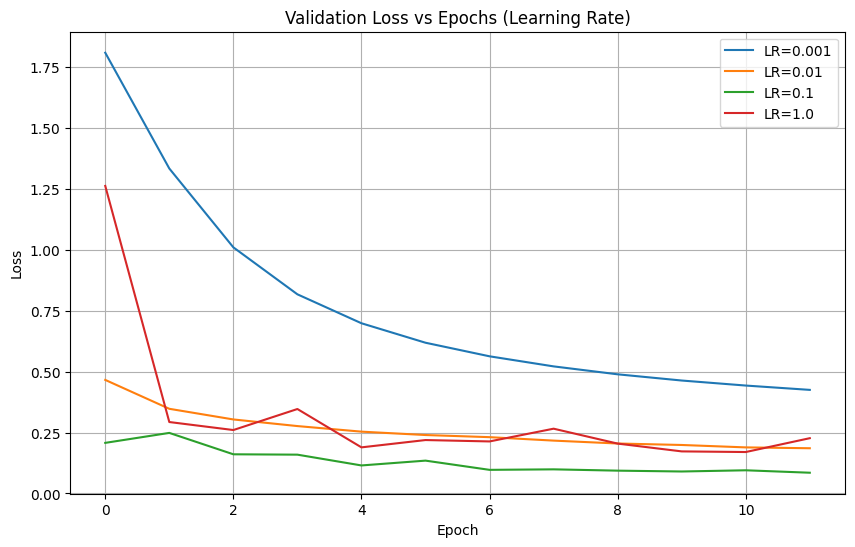

In [56]:
plt.figure(figsize=(10,6))
for lr, h in histories_lr.items():
    plt.plot(h['val_loss_mean'], label=f'LR={lr}')
plt.title("Validation Loss vs Epochs (Learning Rate)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Batch size tuning

In [57]:
batch_sizes = [16, 32, 64, 128]
histories_bs = {}

for bs in batch_sizes:
    print(f"\n🔹 Training with batch size = {bs}")
    model = FeedforwardNeuralNet([784, 128, 64, 10], activation='relu', init='he')
    train_loader, val_loader, _ = get_custom_mnist_dataloaders(batch_size=bs)
    history = train_model(model, train_loader, val_loader, epochs=12, lr=0.01, device=DEVICE)
    histories_bs[bs] = history




🔹 Training with batch size = 16


Epoch 1: Train Loss 0.5043 ± 0.4117, Train Acc 0.8590 ± 0.1375 | Val Loss 0.3023 ± 0.1956, Val Acc 0.9137 ± 0.0726


Epoch 2: Train Loss 0.2534 ± 0.1851, Train Acc 0.9263 ± 0.0647 | Val Loss 0.2264 ± 0.1760, Val Acc 0.9340 ± 0.0631


Epoch 3: Train Loss 0.1990 ± 0.1631, Train Acc 0.9423 ± 0.0591 | Val Loss 0.1857 ± 0.1619, Val Acc 0.9469 ± 0.0572


Epoch 4: Train Loss 0.1636 ± 0.1529, Train Acc 0.9539 ± 0.0537 | Val Loss 0.1604 ± 0.1503, Val Acc 0.9537 ± 0.0515


Epoch 5: Train Loss 0.1404 ± 0.1370, Train Acc 0.9598 ± 0.0486 | Val Loss 0.1436 ± 0.1460, Val Acc 0.9595 ± 0.0493


Epoch 6: Train Loss 0.1212 ± 0.1296, Train Acc 0.9657 ± 0.0456 | Val Loss 0.1378 ± 0.1438, Val Acc 0.9596 ± 0.0478


Epoch 7: Train Loss 0.1071 ± 0.1197, Train Acc 0.9691 ± 0.0438 | Val Loss 0.1222 ± 0.1361, Val Acc 0.9636 ± 0.0473


Epoch 8: Train Loss 0.0950 ± 0.1076, Train Acc 0.9724 ± 0.0402 | Val Loss 0.1173 ± 0.1355, Val Acc 0.9654 ± 0.0467


Epoch 9: Train Loss 0.0852 ± 0.1037, Train Acc 0.9760 ± 0.0380 | Val Loss 0.1108 ± 0.1327, Val Acc 0.9665 ± 0.0456


Epoch 10: Train Loss 0.0764 ± 0.0944, Train Acc 0.9783 ± 0.0361 | Val Loss 0.1085 ± 0.1358, Val Acc 0.9691 ± 0.0436


Epoch 11: Train Loss 0.0689 ± 0.0896, Train Acc 0.9807 ± 0.0347 | Val Loss 0.1042 ± 0.1335, Val Acc 0.9688 ± 0.0431


Epoch 12: Train Loss 0.0624 ± 0.0818, Train Acc 0.9822 ± 0.0328 | Val Loss 0.0994 ± 0.1328, Val Acc 0.9706 ± 0.0426

🔹 Training with batch size = 32


Epoch 1: Train Loss 0.6682 ± 0.4862, Train Acc 0.8225 ± 0.1562 | Val Loss 0.3441 ± 0.1349, Val Acc 0.9036 ± 0.0551


Epoch 2: Train Loss 0.3105 ± 0.1377, Train Acc 0.9120 ± 0.0498 | Val Loss 0.2783 ± 0.1309, Val Acc 0.9190 ± 0.0482


Epoch 3: Train Loss 0.2557 ± 0.1311, Train Acc 0.9283 ± 0.0448 | Val Loss 0.2395 ± 0.1242, Val Acc 0.9309 ± 0.0441


Epoch 4: Train Loss 0.2216 ± 0.1241, Train Acc 0.9374 ± 0.0420 | Val Loss 0.2207 ± 0.1190, Val Acc 0.9349 ± 0.0435


Epoch 5: Train Loss 0.1958 ± 0.1126, Train Acc 0.9445 ± 0.0399 | Val Loss 0.1974 ± 0.1177, Val Acc 0.9410 ± 0.0424


Epoch 6: Train Loss 0.1758 ± 0.1064, Train Acc 0.9499 ± 0.0383 | Val Loss 0.1777 ± 0.1122, Val Acc 0.9478 ± 0.0396


Epoch 7: Train Loss 0.1600 ± 0.1016, Train Acc 0.9541 ± 0.0356 | Val Loss 0.1683 ± 0.1095, Val Acc 0.9510 ± 0.0386


Epoch 8: Train Loss 0.1462 ± 0.1002, Train Acc 0.9577 ± 0.0357 | Val Loss 0.1573 ± 0.1079, Val Acc 0.9543 ± 0.0374


Epoch 9: Train Loss 0.1346 ± 0.0927, Train Acc 0.9609 ± 0.0337 | Val Loss 0.1499 ± 0.1061, Val Acc 0.9578 ± 0.0357


Epoch 10: Train Loss 0.1246 ± 0.0893, Train Acc 0.9640 ± 0.0321 | Val Loss 0.1418 ± 0.1026, Val Acc 0.9593 ± 0.0351


Epoch 11: Train Loss 0.1157 ± 0.0824, Train Acc 0.9669 ± 0.0308 | Val Loss 0.1379 ± 0.1025, Val Acc 0.9603 ± 0.0344


Epoch 12: Train Loss 0.1079 ± 0.0824, Train Acc 0.9690 ± 0.0307 | Val Loss 0.1298 ± 0.1002, Val Acc 0.9635 ± 0.0328

🔹 Training with batch size = 64


Epoch 1: Train Loss 0.9238 ± 0.5443, Train Acc 0.7552 ± 0.1935 | Val Loss 0.4422 ± 0.0956, Val Acc 0.8835 ± 0.0410


Epoch 2: Train Loss 0.3839 ± 0.1033, Train Acc 0.8945 ± 0.0404 | Val Loss 0.3410 ± 0.0959, Val Acc 0.9035 ± 0.0360


Epoch 3: Train Loss 0.3188 ± 0.0991, Train Acc 0.9102 ± 0.0364 | Val Loss 0.2964 ± 0.0920, Val Acc 0.9155 ± 0.0347


Epoch 4: Train Loss 0.2844 ± 0.0939, Train Acc 0.9191 ± 0.0338 | Val Loss 0.2725 ± 0.0904, Val Acc 0.9225 ± 0.0332


Epoch 5: Train Loss 0.2604 ± 0.0963, Train Acc 0.9259 ± 0.0327 | Val Loss 0.2539 ± 0.0880, Val Acc 0.9250 ± 0.0331


Epoch 6: Train Loss 0.2411 ± 0.0839, Train Acc 0.9313 ± 0.0314 | Val Loss 0.2375 ± 0.0859, Val Acc 0.9306 ± 0.0297


Epoch 7: Train Loss 0.2256 ± 0.0878, Train Acc 0.9359 ± 0.0300 | Val Loss 0.2254 ± 0.0834, Val Acc 0.9338 ± 0.0276


Epoch 8: Train Loss 0.2121 ± 0.0793, Train Acc 0.9392 ± 0.0285 | Val Loss 0.2149 ± 0.0808, Val Acc 0.9370 ± 0.0276


Epoch 9: Train Loss 0.1998 ± 0.0831, Train Acc 0.9428 ± 0.0298 | Val Loss 0.2049 ± 0.0797, Val Acc 0.9411 ± 0.0276


Epoch 10: Train Loss 0.1889 ± 0.0785, Train Acc 0.9469 ± 0.0283 | Val Loss 0.1958 ± 0.0781, Val Acc 0.9445 ± 0.0278


Epoch 11: Train Loss 0.1801 ± 0.0791, Train Acc 0.9490 ± 0.0270 | Val Loss 0.1908 ± 0.0798, Val Acc 0.9450 ± 0.0284


Epoch 12: Train Loss 0.1713 ± 0.0724, Train Acc 0.9515 ± 0.0255 | Val Loss 0.1829 ± 0.0771, Val Acc 0.9474 ± 0.0277

🔹 Training with batch size = 128


Epoch 1: Train Loss 1.3116 ± 0.5004, Train Acc 0.6537 ± 0.1916 | Val Loss 0.6897 ± 0.0584, Val Acc 0.8326 ± 0.0322


Epoch 2: Train Loss 0.5504 ± 0.0889, Train Acc 0.8539 ± 0.0336 | Val Loss 0.4551 ± 0.0652, Val Acc 0.8779 ± 0.0299


Epoch 3: Train Loss 0.4215 ± 0.0685, Train Acc 0.8842 ± 0.0283 | Val Loss 0.3865 ± 0.0670, Val Acc 0.8920 ± 0.0270


Epoch 4: Train Loss 0.3679 ± 0.0674, Train Acc 0.8975 ± 0.0265 | Val Loss 0.3444 ± 0.0663, Val Acc 0.9033 ± 0.0263


Epoch 5: Train Loss 0.3352 ± 0.0716, Train Acc 0.9056 ± 0.0267 | Val Loss 0.3238 ± 0.0668, Val Acc 0.9067 ± 0.0248


Epoch 6: Train Loss 0.3125 ± 0.0683, Train Acc 0.9118 ± 0.0244 | Val Loss 0.3025 ± 0.0651, Val Acc 0.9127 ± 0.0252


Epoch 7: Train Loss 0.2956 ± 0.0737, Train Acc 0.9168 ± 0.0252 | Val Loss 0.2881 ± 0.0653, Val Acc 0.9165 ± 0.0245


Epoch 8: Train Loss 0.2801 ± 0.0649, Train Acc 0.9208 ± 0.0227 | Val Loss 0.2765 ± 0.0636, Val Acc 0.9207 ± 0.0233


Epoch 9: Train Loss 0.2698 ± 0.0759, Train Acc 0.9239 ± 0.0261 | Val Loss 0.2680 ± 0.0629, Val Acc 0.9215 ± 0.0239


Epoch 10: Train Loss 0.2572 ± 0.0641, Train Acc 0.9272 ± 0.0225 | Val Loss 0.2556 ± 0.0619, Val Acc 0.9267 ± 0.0223


Epoch 11: Train Loss 0.2485 ± 0.0648, Train Acc 0.9304 ± 0.0222 | Val Loss 0.2497 ± 0.0608, Val Acc 0.9290 ± 0.0216


Epoch 12: Train Loss 0.2387 ± 0.0632, Train Acc 0.9328 ± 0.0221 | Val Loss 0.2406 ± 0.0597, Val Acc 0.9298 ± 0.0221


Plot validation loss

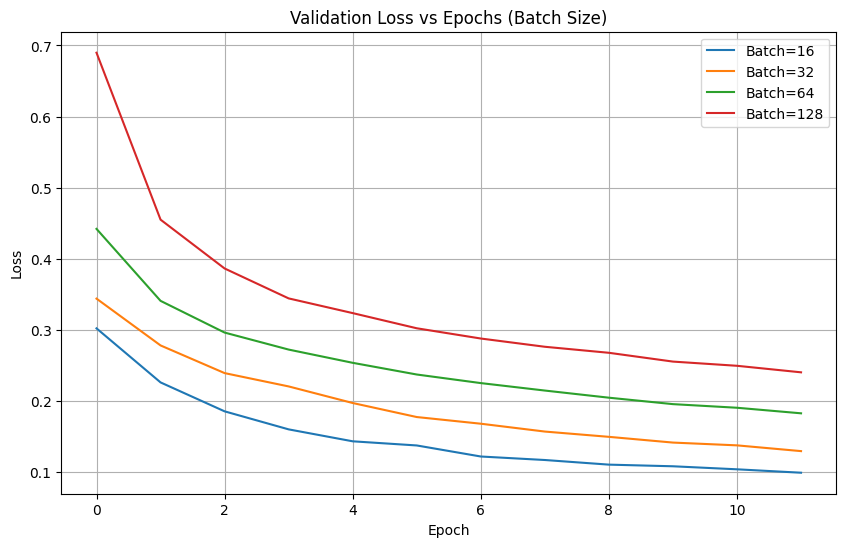

In [58]:
plt.figure(figsize=(10,6))
for bs, h in histories_bs.items():
    plt.plot(h['val_loss_mean'], label=f'Batch={bs}')
plt.title("Validation Loss vs Epochs (Batch Size)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Architecture tuning

In [59]:
architectures = {
    "2 hidden (128,64)": [784, 128, 64, 10],
    "3 hidden (256,128,64)": [784, 256, 128, 64, 10],
    "4 hidden (512,256,128,64)": [784, 512, 256, 128, 64, 10],
    "5 hidden (512,256,128,64,32)": [784, 512, 256, 128, 64, 32, 10]
}

results_arch = []

for name, layers in architectures.items():
    print(f"\n🔹 Training architecture: {name}")
    model = FeedforwardNeuralNet(layers, activation='relu', init='he')
    train_loader, val_loader, _ = get_custom_mnist_dataloaders(batch_size=64)
    history = train_model(model, train_loader, val_loader, epochs=12, lr=0.01, device=DEVICE)
    best_val_acc = max(history['val_acc_mean'])
    results_arch.append((name, best_val_acc))



🔹 Training architecture: 2 hidden (128,64)


Epoch 1: Train Loss 0.9721 ± 0.5457, Train Acc 0.7501 ± 0.1897 | Val Loss 0.4566 ± 0.0900, Val Acc 0.8787 ± 0.0407


Epoch 2: Train Loss 0.3955 ± 0.1011, Train Acc 0.8920 ± 0.0403 | Val Loss 0.3462 ± 0.0928, Val Acc 0.9009 ± 0.0349


Epoch 3: Train Loss 0.3256 ± 0.0998, Train Acc 0.9091 ± 0.0362 | Val Loss 0.3099 ± 0.0929, Val Acc 0.9096 ± 0.0352


Epoch 4: Train Loss 0.2901 ± 0.0955, Train Acc 0.9191 ± 0.0339 | Val Loss 0.2789 ± 0.0896, Val Acc 0.9179 ± 0.0327


Epoch 5: Train Loss 0.2650 ± 0.0948, Train Acc 0.9256 ± 0.0334 | Val Loss 0.2551 ± 0.0855, Val Acc 0.9251 ± 0.0303


Epoch 6: Train Loss 0.2457 ± 0.0943, Train Acc 0.9307 ± 0.0335 | Val Loss 0.2417 ± 0.0854, Val Acc 0.9305 ± 0.0297


Epoch 7: Train Loss 0.2298 ± 0.0880, Train Acc 0.9358 ± 0.0304 | Val Loss 0.2272 ± 0.0823, Val Acc 0.9319 ± 0.0291


Epoch 8: Train Loss 0.2156 ± 0.0852, Train Acc 0.9398 ± 0.0310 | Val Loss 0.2173 ± 0.0804, Val Acc 0.9365 ± 0.0270


Epoch 9: Train Loss 0.2034 ± 0.0839, Train Acc 0.9428 ± 0.0299 | Val Loss 0.2072 ± 0.0794, Val Acc 0.9386 ± 0.0276


Epoch 10: Train Loss 0.1929 ± 0.0821, Train Acc 0.9462 ± 0.0283 | Val Loss 0.1976 ± 0.0777, Val Acc 0.9428 ± 0.0268


Epoch 11: Train Loss 0.1833 ± 0.0755, Train Acc 0.9477 ± 0.0274 | Val Loss 0.1906 ± 0.0771, Val Acc 0.9453 ± 0.0256


Epoch 12: Train Loss 0.1748 ± 0.0753, Train Acc 0.9505 ± 0.0273 | Val Loss 0.1851 ± 0.0763, Val Acc 0.9465 ± 0.0269

🔹 Training architecture: 3 hidden (256,128,64)


Epoch 1: Train Loss 0.8453 ± 0.5476, Train Acc 0.7686 ± 0.1926 | Val Loss 0.3924 ± 0.0933, Val Acc 0.8911 ± 0.0377


Epoch 2: Train Loss 0.3427 ± 0.1002, Train Acc 0.9033 ± 0.0369 | Val Loss 0.3028 ± 0.0903, Val Acc 0.9116 ± 0.0355


Epoch 3: Train Loss 0.2793 ± 0.0937, Train Acc 0.9210 ± 0.0336 | Val Loss 0.2553 ± 0.0859, Val Acc 0.9266 ± 0.0320


Epoch 4: Train Loss 0.2418 ± 0.0873, Train Acc 0.9304 ± 0.0315 | Val Loss 0.2364 ± 0.0842, Val Acc 0.9289 ± 0.0333


Epoch 5: Train Loss 0.2147 ± 0.0866, Train Acc 0.9390 ± 0.0301 | Val Loss 0.2249 ± 0.0836, Val Acc 0.9328 ± 0.0308


Epoch 6: Train Loss 0.1935 ± 0.0792, Train Acc 0.9452 ± 0.0291 | Val Loss 0.1957 ± 0.0780, Val Acc 0.9430 ± 0.0290


Epoch 7: Train Loss 0.1759 ± 0.0731, Train Acc 0.9497 ± 0.0260 | Val Loss 0.1920 ± 0.0800, Val Acc 0.9425 ± 0.0290


Epoch 8: Train Loss 0.1618 ± 0.0748, Train Acc 0.9535 ± 0.0253 | Val Loss 0.1714 ± 0.0731, Val Acc 0.9483 ± 0.0279


Epoch 9: Train Loss 0.1491 ± 0.0711, Train Acc 0.9582 ± 0.0251 | Val Loss 0.1589 ± 0.0707, Val Acc 0.9541 ± 0.0261


Epoch 10: Train Loss 0.1377 ± 0.0689, Train Acc 0.9602 ± 0.0246 | Val Loss 0.1512 ± 0.0700, Val Acc 0.9561 ± 0.0260


Epoch 11: Train Loss 0.1286 ± 0.0638, Train Acc 0.9632 ± 0.0229 | Val Loss 0.1498 ± 0.0692, Val Acc 0.9559 ± 0.0247


Epoch 12: Train Loss 0.1198 ± 0.0630, Train Acc 0.9651 ± 0.0232 | Val Loss 0.1405 ± 0.0693, Val Acc 0.9585 ± 0.0265

🔹 Training architecture: 4 hidden (512,256,128,64)


Epoch 1: Train Loss 0.7786 ± 0.5671, Train Acc 0.7863 ± 0.1910 | Val Loss 0.3840 ± 0.0987, Val Acc 0.8821 ± 0.0389


Epoch 2: Train Loss 0.2957 ± 0.0996, Train Acc 0.9150 ± 0.0367 | Val Loss 0.2875 ± 0.0953, Val Acc 0.9166 ± 0.0358


Epoch 3: Train Loss 0.2319 ± 0.0862, Train Acc 0.9340 ± 0.0308 | Val Loss 0.2184 ± 0.0827, Val Acc 0.9362 ± 0.0308


Epoch 4: Train Loss 0.1944 ± 0.0834, Train Acc 0.9433 ± 0.0297 | Val Loss 0.2128 ± 0.0841, Val Acc 0.9374 ± 0.0299


Epoch 5: Train Loss 0.1676 ± 0.0723, Train Acc 0.9517 ± 0.0268 | Val Loss 0.1768 ± 0.0777, Val Acc 0.9478 ± 0.0271


Epoch 6: Train Loss 0.1479 ± 0.0725, Train Acc 0.9573 ± 0.0249 | Val Loss 0.1694 ± 0.0764, Val Acc 0.9519 ± 0.0271


Epoch 7: Train Loss 0.1317 ± 0.0651, Train Acc 0.9627 ± 0.0233 | Val Loss 0.1509 ± 0.0731, Val Acc 0.9571 ± 0.0241


Epoch 8: Train Loss 0.1180 ± 0.0628, Train Acc 0.9663 ± 0.0227 | Val Loss 0.1416 ± 0.0708, Val Acc 0.9589 ± 0.0257


Epoch 9: Train Loss 0.1074 ± 0.0572, Train Acc 0.9693 ± 0.0203 | Val Loss 0.1412 ± 0.0715, Val Acc 0.9595 ± 0.0244


Epoch 10: Train Loss 0.0981 ± 0.0573, Train Acc 0.9717 ± 0.0206 | Val Loss 0.1263 ± 0.0682, Val Acc 0.9641 ± 0.0227


Epoch 11: Train Loss 0.0888 ± 0.0552, Train Acc 0.9746 ± 0.0211 | Val Loss 0.1297 ± 0.0720, Val Acc 0.9625 ± 0.0240


Epoch 12: Train Loss 0.0813 ± 0.0509, Train Acc 0.9766 ± 0.0188 | Val Loss 0.1220 ± 0.0681, Val Acc 0.9637 ± 0.0236

🔹 Training architecture: 5 hidden (512,256,128,64,32)


Epoch 1: Train Loss 0.7891 ± 0.5603, Train Acc 0.7672 ± 0.1880 | Val Loss 0.4066 ± 0.1087, Val Acc 0.8716 ± 0.0415


Epoch 2: Train Loss 0.2908 ± 0.0990, Train Acc 0.9151 ± 0.0358 | Val Loss 0.2413 ± 0.0849, Val Acc 0.9296 ± 0.0299


Epoch 3: Train Loss 0.2194 ± 0.0906, Train Acc 0.9360 ± 0.0313 | Val Loss 0.2343 ± 0.0901, Val Acc 0.9289 ± 0.0320


Epoch 4: Train Loss 0.1767 ± 0.0807, Train Acc 0.9495 ± 0.0283 | Val Loss 0.2161 ± 0.0855, Val Acc 0.9314 ± 0.0294


Epoch 5: Train Loss 0.1504 ± 0.0804, Train Acc 0.9572 ± 0.0258 | Val Loss 0.2253 ± 0.0861, Val Acc 0.9338 ± 0.0304


Epoch 6: Train Loss 0.1277 ± 0.0697, Train Acc 0.9632 ± 0.0240 | Val Loss 0.1524 ± 0.0749, Val Acc 0.9530 ± 0.0285


Epoch 7: Train Loss 0.1086 ± 0.0571, Train Acc 0.9681 ± 0.0211 | Val Loss 0.1301 ± 0.0674, Val Acc 0.9615 ± 0.0220


Epoch 8: Train Loss 0.0958 ± 0.0538, Train Acc 0.9721 ± 0.0200 | Val Loss 0.1233 ± 0.0678, Val Acc 0.9636 ± 0.0224


Epoch 9: Train Loss 0.0838 ± 0.0524, Train Acc 0.9759 ± 0.0190 | Val Loss 0.1206 ± 0.0691, Val Acc 0.9631 ± 0.0232


Epoch 10: Train Loss 0.0735 ± 0.0454, Train Acc 0.9789 ± 0.0179 | Val Loss 0.1285 ± 0.0729, Val Acc 0.9597 ± 0.0251


Epoch 11: Train Loss 0.0645 ± 0.0425, Train Acc 0.9815 ± 0.0165 | Val Loss 0.1197 ± 0.0733, Val Acc 0.9642 ± 0.0212


Epoch 12: Train Loss 0.0569 ± 0.0398, Train Acc 0.9845 ± 0.0147 | Val Loss 0.1321 ± 0.0796, Val Acc 0.9601 ± 0.0242


Architecture comparison

In [60]:
import pandas as pd

arch_table = pd.DataFrame(results_arch, columns=["Architecture", "Best Validation Accuracy"])
display(arch_table)


,Architecture,Best Validation Accuracy
0,"2 hidden (128,64)",0.946537
1,"3 hidden (256,128,64)",0.958476
2,"4 hidden (512,256,128,64)",0.964065
3,"5 hidden (512,256,128,64,32)",0.964231


Testing

In [61]:
def get_test_accuracy(model_arch, saved_model_path, test_loader, device):
    model = FeedforwardNeuralNet(model_arch, activation='relu', init='he')
    try:
        model.load_state_dict(torch.load(saved_model_path, map_location=device))
    except FileNotFoundError:
        print(f"Error: Model file not found at {saved_model_path}")
        return -1.0

    model.to(device)
    model.eval()
    all_preds = []
    all_targets = []

    print(f"Evaluating model {saved_model_path} on test set...")
    with torch.no_grad():
        for features, targets in test_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features)
            _, preds = torch.max(logits, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_preds)
    return accuracy

Importing required libs

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tqdm import tqdm
import time
import copy
import os

In [64]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

train_loader, val_loader, test_loader = get_custom_mnist_dataloaders(batch_size=64)

if train_loader:
    print("DataLoaders created successfully.")
    EPOCHS = 12
    models_to_train = {
        "NN (Baseline)": {
            "arch": [784, 128, 64, 10],
            "lr": 0.01,
            "path": "./nn_baseline.pth"
        },
        "NN (Best LR)": {
            "arch": [784, 128, 64, 10],
            "lr": 0.1,
            "path": "./nn_best_lr.pth"
        },
        "NN (Best Arch)": {
            "arch": [784, 512, 256, 128, 64, 32, 10],
            "lr": 0.01,
            "path": "./nn_best_arch.pth"
        }
    }
    test_results = {}

    # --- Train all models ---
    for model_name, config in models_to_train.items():
        print(f"\n--- Training {model_name} ---")
        model = FeedforwardNeuralNet(config["arch"], activation='relu', init='he')
        train_model(model, train_loader, val_loader,
                      epochs=EPOCHS, lr=config["lr"],
                      device=DEVICE, save_best_path=config["path"])

    # --- Evaluate all models ---
    print("\n--- Evaluating Models on Test Set ---")
    for model_name, config in models_to_train.items():
        test_acc = get_test_accuracy(model_arch=config["arch"],
                                     saved_model_path=config["path"],
                                     test_loader=test_loader,
                                     device=DEVICE)
        test_results[model_name] = test_acc

    # --- Print Final Summary ---
    print("\n--- Final Test Accuracy Summary ---")
    for name, acc in test_results.items():
        print(f"{name}: {acc:.4f}")
else:
    print("Failed to load data. Halting execution.")

Using device: cuda
DataLoaders created successfully.

--- Training NN (Baseline) ---


Epoch 1: Train Loss 0.8914 ± 0.5179, Train Acc 0.7682 ± 0.1756 | Val Loss 0.4405 ± 0.0884, Val Acc 0.8796 ± 0.0388
✅ Saved best model to ./nn_baseline.pth


Epoch 2: Train Loss 0.3832 ± 0.1034, Train Acc 0.8945 ± 0.0384 | Val Loss 0.3364 ± 0.0913, Val Acc 0.9045 ± 0.0356
✅ Saved best model to ./nn_baseline.pth


Epoch 3: Train Loss 0.3191 ± 0.0973, Train Acc 0.9090 ± 0.0348 | Val Loss 0.3083 ± 0.0935, Val Acc 0.9097 ± 0.0360
✅ Saved best model to ./nn_baseline.pth


Epoch 4: Train Loss 0.2858 ± 0.0931, Train Acc 0.9181 ± 0.0331 | Val Loss 0.2777 ± 0.0896, Val Acc 0.9176 ± 0.0339
✅ Saved best model to ./nn_baseline.pth


Epoch 5: Train Loss 0.2630 ± 0.0904, Train Acc 0.9249 ± 0.0319 | Val Loss 0.2554 ± 0.0878, Val Acc 0.9263 ± 0.0323
✅ Saved best model to ./nn_baseline.pth


Epoch 6: Train Loss 0.2447 ± 0.0884, Train Acc 0.9297 ± 0.0315 | Val Loss 0.2435 ± 0.0867, Val Acc 0.9283 ± 0.0313
✅ Saved best model to ./nn_baseline.pth


Epoch 7: Train Loss 0.2291 ± 0.0889, Train Acc 0.9351 ± 0.0302 | Val Loss 0.2274 ± 0.0844, Val Acc 0.9344 ± 0.0292
✅ Saved best model to ./nn_baseline.pth


Epoch 8: Train Loss 0.2160 ± 0.0872, Train Acc 0.9381 ± 0.0301 | Val Loss 0.2175 ± 0.0827, Val Acc 0.9366 ± 0.0297
✅ Saved best model to ./nn_baseline.pth


Epoch 9: Train Loss 0.2039 ± 0.0879, Train Acc 0.9416 ± 0.0302 | Val Loss 0.2068 ± 0.0808, Val Acc 0.9410 ± 0.0287
✅ Saved best model to ./nn_baseline.pth


Epoch 10: Train Loss 0.1933 ± 0.0796, Train Acc 0.9450 ± 0.0285 | Val Loss 0.2022 ± 0.0825, Val Acc 0.9423 ± 0.0295
✅ Saved best model to ./nn_baseline.pth


Epoch 11: Train Loss 0.1836 ± 0.0820, Train Acc 0.9482 ± 0.0275 | Val Loss 0.1926 ± 0.0794, Val Acc 0.9461 ± 0.0276
✅ Saved best model to ./nn_baseline.pth


Epoch 12: Train Loss 0.1752 ± 0.0764, Train Acc 0.9502 ± 0.0277 | Val Loss 0.1858 ± 0.0794, Val Acc 0.9472 ± 0.0284
✅ Saved best model to ./nn_baseline.pth

--- Training NN (Best LR) ---


Epoch 1: Train Loss 0.3879 ± 0.3043, Train Acc 0.8884 ± 0.0947 | Val Loss 0.3015 ± 0.0990, Val Acc 0.9104 ± 0.0340
✅ Saved best model to ./nn_best_lr.pth


Epoch 2: Train Loss 0.1826 ± 0.0834, Train Acc 0.9456 ± 0.0292 | Val Loss 0.1834 ± 0.0734, Val Acc 0.9455 ± 0.0265
✅ Saved best model to ./nn_best_lr.pth


Epoch 3: Train Loss 0.1299 ± 0.0658, Train Acc 0.9612 ± 0.0239 | Val Loss 0.1251 ± 0.0659, Val Acc 0.9628 ± 0.0225
✅ Saved best model to ./nn_best_lr.pth


Epoch 4: Train Loss 0.1007 ± 0.0561, Train Acc 0.9695 ± 0.0215 | Val Loss 0.1708 ± 0.0844, Val Acc 0.9455 ± 0.0303


Epoch 5: Train Loss 0.0811 ± 0.0494, Train Acc 0.9754 ± 0.0198 | Val Loss 0.1118 ± 0.0664, Val Acc 0.9649 ± 0.0226
✅ Saved best model to ./nn_best_lr.pth


Epoch 6: Train Loss 0.0664 ± 0.0449, Train Acc 0.9799 ± 0.0180 | Val Loss 0.0972 ± 0.0647, Val Acc 0.9706 ± 0.0211
✅ Saved best model to ./nn_best_lr.pth


Epoch 7: Train Loss 0.0551 ± 0.0382, Train Acc 0.9835 ± 0.0160 | Val Loss 0.0949 ± 0.0673, Val Acc 0.9705 ± 0.0210
✅ Saved best model to ./nn_best_lr.pth


Epoch 8: Train Loss 0.0469 ± 0.0373, Train Acc 0.9863 ± 0.0149 | Val Loss 0.1481 ± 0.0910, Val Acc 0.9550 ± 0.0253


Epoch 9: Train Loss 0.0388 ± 0.0309, Train Acc 0.9886 ± 0.0133 | Val Loss 0.0885 ± 0.0664, Val Acc 0.9735 ± 0.0192
✅ Saved best model to ./nn_best_lr.pth


Epoch 10: Train Loss 0.0325 ± 0.0274, Train Acc 0.9904 ± 0.0125 | Val Loss 0.0862 ± 0.0672, Val Acc 0.9745 ± 0.0194
✅ Saved best model to ./nn_best_lr.pth


Epoch 11: Train Loss 0.0279 ± 0.0242, Train Acc 0.9920 ± 0.0106 | Val Loss 0.0939 ± 0.0762, Val Acc 0.9725 ± 0.0204


Epoch 12: Train Loss 0.0223 ± 0.0199, Train Acc 0.9942 ± 0.0096 | Val Loss 0.0861 ± 0.0727, Val Acc 0.9756 ± 0.0185
✅ Saved best model to ./nn_best_lr.pth

--- Training NN (Best Arch) ---


Epoch 1: Train Loss 0.8069 ± 0.5732, Train Acc 0.7604 ± 0.2056 | Val Loss 0.3764 ± 0.0992, Val Acc 0.8911 ± 0.0378
✅ Saved best model to ./nn_best_arch.pth


Epoch 2: Train Loss 0.2881 ± 0.0999, Train Acc 0.9163 ± 0.0350 | Val Loss 0.2490 ± 0.0833, Val Acc 0.9261 ± 0.0320
✅ Saved best model to ./nn_best_arch.pth


Epoch 3: Train Loss 0.2186 ± 0.0866, Train Acc 0.9358 ± 0.0301 | Val Loss 0.2418 ± 0.0874, Val Acc 0.9308 ± 0.0293
✅ Saved best model to ./nn_best_arch.pth


Epoch 4: Train Loss 0.1787 ± 0.0798, Train Acc 0.9474 ± 0.0283 | Val Loss 0.4677 ± 0.1206, Val Acc 0.8497 ± 0.0403


Epoch 5: Train Loss 0.1515 ± 0.0741, Train Acc 0.9558 ± 0.0255 | Val Loss 0.1931 ± 0.0809, Val Acc 0.9410 ± 0.0293
✅ Saved best model to ./nn_best_arch.pth


Epoch 6: Train Loss 0.1309 ± 0.0650, Train Acc 0.9616 ± 0.0235 | Val Loss 0.1581 ± 0.0748, Val Acc 0.9526 ± 0.0272
✅ Saved best model to ./nn_best_arch.pth


Epoch 7: Train Loss 0.1145 ± 0.0591, Train Acc 0.9666 ± 0.0219 | Val Loss 0.1358 ± 0.0687, Val Acc 0.9607 ± 0.0236
✅ Saved best model to ./nn_best_arch.pth


Epoch 8: Train Loss 0.1008 ± 0.0597, Train Acc 0.9696 ± 0.0221 | Val Loss 0.1969 ± 0.0995, Val Acc 0.9408 ± 0.0324


Epoch 9: Train Loss 0.0897 ± 0.0529, Train Acc 0.9733 ± 0.0204 | Val Loss 0.1248 ± 0.0693, Val Acc 0.9627 ± 0.0229
✅ Saved best model to ./nn_best_arch.pth


Epoch 10: Train Loss 0.0787 ± 0.0506, Train Acc 0.9768 ± 0.0192 | Val Loss 0.1379 ± 0.0728, Val Acc 0.9591 ± 0.0234


Epoch 11: Train Loss 0.0699 ± 0.0440, Train Acc 0.9797 ± 0.0172 | Val Loss 0.1137 ± 0.0668, Val Acc 0.9664 ± 0.0210
✅ Saved best model to ./nn_best_arch.pth


Epoch 12: Train Loss 0.0613 ± 0.0444, Train Acc 0.9822 ± 0.0168 | Val Loss 0.1128 ± 0.0687, Val Acc 0.9676 ± 0.0219
✅ Saved best model to ./nn_best_arch.pth

--- Evaluating Models on Test Set ---
Evaluating model ./nn_baseline.pth on test set...
Evaluating model ./nn_best_lr.pth on test set...
Evaluating model ./nn_best_arch.pth on test set...

--- Final Test Accuracy Summary ---
NN (Baseline): 0.9474
NN (Best LR): 0.9754
NN (Best Arch): 0.9676


## Comparative Analysis

The notebook implements three distinct classification models:
1.  **Binary Logistic Regression (A2):** A manual implementation of a linear classifier for a simple binary task (distinguishing digits 0 vs. 1).
2.  **Softmax Regression (A3):** A manual implementation of a linear classifier for the full multi-class task (digits 0–9).
3.  **Feedforward Neural Network (NN) (B/C):** A PyTorch `nn.Module` implementation of a non-linear classifier, which is tuned for hyperparameters (learning rate, batch size, and architecture).

The best-performing model on the **validation set** was the **Feedforward Neural Network (NN)** from Part C, specifically the 2-hidden-layer model (`[784, 128, 64, 10]`) trained with a **learning rate of 0.1**, which achieved a **97.54% test accuracy**.

In contrast, the **Softmax Regression** model achieved a final **test accuracy of 91.24%**.

### Performance Summary Table (Multi-class Models)

This table compares the multi-class models (Softmax Regression and the various Neural Networks) developed in the notebook.

| Model | Implementation | Architecture | Parameters | Final Validation Accuracy | Final Test Accuracy |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Softmax Regression** (A3) | Manual (Torch) | Linear (784, 10) | 7,850 | 91.69% (at 50 epochs) | **91.24%** |
| **NN (Baseline)** (B) | PyTorch (NN) | 2-Hidden (128, 64) | 109,386 | 94.98% (at 12 epochs) | 94.74% |
| **NN (Best LR)** (C) | PyTorch (NN) | 2-Hidden (128, 64) | 109,386 | 97.71% (at 12 epochs) | **97.54%** |
| **NN (Best Arch)** (C) | PyTorch (NN) | 5-Hidden (512...32) | 576,810 | 96.42% (at 12 epochs) |  96.76% |

### Computational Complexity and Training Time

* **Logistic/Softmax Regression:** These are linear models with very low computational complexity. They consist of a single layer of weights and biases, resulting in only **7,850 parameters** (784 inputs * 10 outputs + 10 biases) for the Softmax model. Training is extremely fast as it involves a single matrix multiplication, a softmax, and a straightforward gradient calculation. While the notebook ran it for 50 epochs, it converges to its peak performance relatively quickly.
* **Neural Network:** The NNs are significantly more complex. The baseline 2-hidden-layer model (`[784, 128, 64, 10]`) already has **109,386 parameters**, and the 5-hidden-layer model has **576,810**. Training involves forward and backward propagation through multiple layers and non-linear activation functions (ReLU), making each epoch much more computationally expensive and time-consuming than the Softmax model.

### When to Use Each Approach

* **Logistic/Softmax Regression (Linear Models):** These models are best used as a **quick baseline** for classification problems. They are fast to train, highly interpretable (you can inspect the weights for each class), and work well if the data is simple and **linearly separable**. For MNIST, where the classes are highly complex and non-linear (e.g., the pixels for a '3' and an '8' overlap significantly), a linear model is fundamentally limited, as seen by its **91.24%** accuracy.
* **Neural Network (Non-Linear Model):** NNs are the standard approach for complex, high-dimensional pattern recognition tasks like image classification. The multiple layers and non-linear ReLU activations allow the model to learn a hierarchy of features (from simple edges to complex shapes like loops), creating sophisticated, non-linear decision boundaries. This is why even a simple NN achieves significantly higher test accuracy (97.54%) than the linear Softmax model. It should be used when high accuracy is the primary goal and the underlying data patterns are non-linear.

---

## Best Model Evaluation

The notebook's hyperparameter tuning (Part C) identified that the **2-hidden-layer Neural Network with a learning rate of 0.1** was the optimal configuration, achieving **97.54%** accuracy on the *test set*.


### Final Accuracy and Confusion Matrix (Softmax Regression)

* **Final Test Accuracy:** **91.24%**
* **Total Misclassified:** 1227 out of 14,000 test samples.

**Per-Class Accuracy (from Confusion Matrix):**
The model performed best on "simple" digits like 0, 1, and 6, but struggled with more complex or visually similar digits.

* **Digit 0:** 96.67%
* **Digit 1:** 97.02%
* **Digit 2:** 87.55%
* **Digit 3:** 89.08%
* **Digit 4:** 91.50%
* **Digit 5:** **84.48% (Worst)**
* **Digit 6:** 95.78%
* **Digit 7:** 92.53%
* **Digit 8:** 87.69%
* **Digit 9:** 88.71%

### Analysis of Misclassified Examples

The notebook visualizes several misclassified examples from the Softmax model's test results. The errors highlight the model's limitations:

* **True: 7, Pred: 2:** The "7" is slightly slanted and curved, which the model confused with the loop of a "2".
* **True: 4, Pred: 9:** A common error. The loop of the "4" is slightly closed, making it look like a "9".
* **True: 5, Pred: 3:** Another common error. The sharp angles of the "5" are confused with the curves of a "3".
* **True: 6, Pred: 0:** The "6" shown is written with a large, closed loop at the bottom and a small stem, strongly resembling a "0".
* **True: 8, Pred: 3:** The "8" is poorly formed, with the bottom loop not fully closed, making it look like a "3".

These examples show that the model struggles with high intra-class variance (messy handwriting) and low inter-class variance (visually similar digits).

### Insights on Model Limitations (Softmax Regression)

The primary limitation, as demonstrated by the 91.24% accuracy and the types of errors, is the model's **linearity**. A Softmax classifier learns a single hyperplane to separate each class from the others in the 784-dimensional pixel space.

This is insufficient for MNIST because the boundaries between digits are highly non-linear. For example, a model needs to learn "a loop at the top AND a loop at the bottom" to identify an "8". A linear model cannot learn this "AND" relationship; it can only add or subtract the "importance" of each pixel.

This is precisely why the **Neural Network**, with its non-linear ReLU activations and multiple layers, achieved a much higher test accuracy (97.54%). It can build complex decision boundaries to correctly separate even the most ambiguous digits, which the linear Softmax model is fundamentally incapable of.